In [5]:
from glob import glob
import numpy as np

### Create the training dataset

In [2]:
# Extract the subjects' label.
path_labels = '../data/risk_golden_truth.txt'
labels = {}
with open(path_labels, 'r') as f:
    for line in f:
        subject, label = line.split()
        labels[subject] = int(label)

In [3]:
# Create the train dataset from the subjects' posts and label.
txt_path = glob('../data/processed/*')
rows_data = []
for path in txt_path:
   with open(path, 'r+') as f:
      # Split the path, get the filename 
      # (which contains the subject) and remove '.txt'
      subject = path.split('\\')[1][:-4] 
      txt = f.read()
      rows_data.append((subject, txt, labels[subject]))

# Training dataset.
train_data = pd.DataFrame(rows_data, columns=['Subject', 'Text', 'Label'])

In [4]:
train_data

,Subject,Text,Label
0,subject1,Vulcan's ultimate landing at max range is so s...,0
1,subject100,I almost only play Marathon/Huge. I enjoy slow...,0
2,subject1006,http://imgur.com/igov5qk http://imgur.com/vHu8...,0
3,subject1008,What are the list of softwares you use for day...,0
4,subject1011,Subscribe and like will help me #128522;\nLoL\...,0
...,...,...,...
2343,subject9980,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2344,subject9981,\n \n \n \n \n \n \n \n \n \n \n \n \n \n \n ...,0
2345,subject9986,Checkout r/GoGoJoJo against the qualified immu...,0
2346,subject9990,Only took about 10 tries to post correctly lol...,0


### Preprocess the subjects' posts
Text normalization techniques:
- lowercasing 
- whitespace removal
- URL removal
- tokenization
- stopwords removal
- punctuation removal
- stemming

In [5]:
import re
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import RegexpTokenizer

In [6]:
# Normalize all words to lowercase.
train_data["Text"] = train_data["Text"].str.lower()

In [7]:
def remove_whitespace(text):
   """ Removes all whitespaces from a given text."""
   return " ".join(text.split())

In [8]:
# Remove all whitespaces from texts.
train_data["Text"] = train_data["Text"].apply(remove_whitespace)

In [9]:
def remove_URLs(text):
   "Remove URLs from text using regular expressions."
   url_re = re.compile(r'https?://\S+|www\.\S+')
   return url_re.sub(r'', text)

In [10]:
train_data["Text"][2][:200]

'http://imgur.com/igov5qk http://imgur.com/vhu8cjn this was just a lucky run all around. i got some good crew early and then got good system levels like shields and engines. this let me focus on a weap'

In [11]:
# Remove URLs from texts.
train_data["Text"] = train_data["Text"].apply(remove_URLs)

In [12]:
train_data["Text"][2][:200]

'  this was just a lucky run all around. i got some good crew early and then got good system levels like shields and engines. this let me focus on a weapons system, and someone truly blessed me. triple'

In [13]:
# Extract tokens from texts.
train_data["Text"] = train_data["Text"].apply(lambda x: word_tokenize(x))

In [14]:
def remove_punctuation(text):
   tokenizer = RegexpTokenizer(r'\w+')
   no_punct = tokenizer.tokenize(" ".join(text))
   return no_punct

In [15]:
# Removes punctuation from texts.
train_data["Text"] = train_data["Text"].apply(remove_punctuation)

In [16]:
en_stopwords = stopwords.words('english')
def remove_stopwords(text):
   """Removes english stopwords."""
   result = []
   for token in text:
      if token not in en_stopwords:
         result.append(token)

   return result

In [17]:
# Removes stopwords from texts.
train_data["Text"] = train_data["Text"].apply(remove_stopwords)

In [18]:
def stemming(text):
   porter = PorterStemmer()
   result = []
   for word in text:
      result.append(porter.stem(word))

   return result

In [19]:
# Apply stemming to words from texts.
train_data["Text"] = train_data["Text"].apply(stemming)

In [20]:
# Save the dataset to a .csv file.
train_data.to_csv('../data/train_dataset.csv')

### Standard ML approaches

In [1]:
import time
import pandas as pd
import numpy as np
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [2]:
# Load the training dataset.
train_data = pd.read_csv('../data/train_dataset.csv')

<AxesSubplot:>

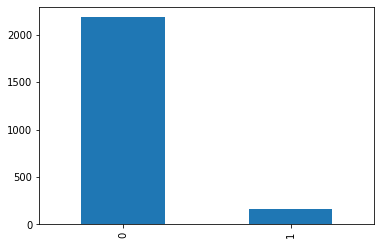

In [3]:
# Visualize the distribution of class labels.
train_data["Label"].value_counts().plot.bar()

### ML experiments
Feature extractors:
- Bag-of-Words
- TF-IDF

Classifiers:
- LinearSVC
- Logistic Regression
- Random Forest
- K-neighbors
- Decision Tree

In [4]:
X = train_data["Text"]
y = train_data["Label"]

# Feature extractors.
feature_extractors = [
CountVectorizer(),
# Ignore words that appear in less than 20% of posts (rare words).
CountVectorizer(min_df=0.2),
# Ignore words that appear in more than 80% of posts (frequent words).
CountVectorizer(max_df=0.8),
CountVectorizer(ngram_range=(2, 2)),
CountVectorizer(ngram_range=(3, 3)),
TfidfVectorizer(),
TfidfVectorizer(min_df=0.2),
TfidfVectorizer(max_df=0.8),
TfidfVectorizer(ngram_range=(2, 2)),
TfidfVectorizer(ngram_range=(3, 3))
]

# Classifiers.
classifiers = [ 
LinearSVC(max_iter=100000), 
LogisticRegression(max_iter=100000), 
RandomForestClassifier(), 
KNeighborsClassifier(), 
DecisionTreeClassifier()
]
# Use a stratified 5-fold CV to try to reduce
# the class imbalance in train/validation splits.
cv = StratifiedKFold(n_splits=5)

In [5]:
scoring = {
'accuracy': make_scorer(accuracy_score),
'precision': make_scorer(precision_score),
'recall': make_scorer(recall_score),
'f1_score': make_scorer(f1_score)
}

for classifier in classifiers:
   for extractor in feature_extractors:
      start_time = time.time()
      pipeline = Pipeline([('extractor', extractor), ('classifier', classifier)])
      scores = cross_validate(pipeline, X, y, cv=cv, scoring=scoring)
      end_time = time.time()
      total_time = round((end_time - start_time)/60, 2)
      
      f1_score = round(np.mean(scores['test_f1_score']), 2)
      precision = round(np.mean(scores['test_precision']), 2)
      recall = round(np.mean(scores['test_recall']), 2)
      acc = round(np.mean(scores['test_accuracy']), 2)

      print("Time: ", total_time, " min")
      print("Experiment: ", str(classifier), "+", str(extractor))
      print("F1 score= ", f1_score, ", 5-fold CV=", scores['test_f1_score'])
      print("Precision= ", precision, ", 5-fold CV=", scores['test_precision'])
      print("Recall= ", recall, ", 5-fold CV=", scores['test_recall'])
      print("Accuracy= ", acc, ", 5-fold CV=", scores['test_accuracy'])
      print("="*100)

Time:  1.23  min
Experiment:  LinearSVC(max_iter=100000) + CountVectorizer()
F1 score=  0.85 , 5-fold CV= [0.82191781 0.87878788 0.84848485 0.85294118 0.8358209 ]
Precision=  0.82 , 5-fold CV= [0.75       0.87878788 0.84848485 0.80555556 0.82352941]
Recall=  0.88 , 5-fold CV= [0.90909091 0.87878788 0.84848485 0.90625    0.84848485]
Accuracy=  0.98 , 5-fold CV= [0.97234043 0.98297872 0.9787234  0.97867804 0.97654584]
Time:  1.17  min
Experiment:  LinearSVC(max_iter=100000) + CountVectorizer(min_df=0.2)
F1 score=  0.82 , 5-fold CV= [0.80555556 0.85294118 0.84848485 0.79411765 0.79411765]
Precision=  0.79 , 5-fold CV= [0.74358974 0.82857143 0.84848485 0.75       0.77142857]
Recall=  0.85 , 5-fold CV= [0.87878788 0.87878788 0.84848485 0.84375    0.81818182]
Accuracy=  0.97 , 5-fold CV= [0.97021277 0.9787234  0.9787234  0.97014925 0.97014925]
Time:  1.24  min
Experiment:  LinearSVC(max_iter=100000) + CountVectorizer(max_df=0.8)
F1 score=  0.86 , 5-fold CV= [0.86486486 0.875      0.85294118 

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time:  6.18  min
Experiment:  LinearSVC(max_iter=100000) + TfidfVectorizer(ngram_range=(3, 3))
F1 score=  0.13 , 5-fold CV= [0.26315789 0.16666667 0.05882353 0.17142857 0.        ]
Precision=  0.8 , 5-fold CV= [1. 1. 1. 1. 0.]
Recall=  0.07 , 5-fold CV= [0.15151515 0.09090909 0.03030303 0.09375    0.        ]
Accuracy=  0.94 , 5-fold CV= [0.94042553 0.93617021 0.93191489 0.93816631 0.92963753]
Time:  2.76  min
Experiment:  LogisticRegression(max_iter=100000) + CountVectorizer()
F1 score=  0.86 , 5-fold CV= [0.84057971 0.90625    0.84848485 0.87878788 0.8358209 ]
Precision=  0.85 , 5-fold CV= [0.80555556 0.93548387 0.84848485 0.85294118 0.82352941]
Recall=  0.87 , 5-fold CV= [0.87878788 0.87878788 0.84848485 0.90625    0.84848485]
Accuracy=  0.98 , 5-fold CV= [0.97659574 0.98723404 0.9787234  0.98294243 0.97654584]
Time:  1.31  min
Experiment:  LogisticRegression(max_iter=100000) + CountVectorizer(min_df=0.2)
F1 score=  0.84 , 5-fold CV= [0.84057971 0.84057971 0.86153846 0.84375    0.83

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time:  6.0  min
Experiment:  LogisticRegression(max_iter=100000) + TfidfVectorizer(ngram_range=(2, 2))
F1 score=  0.1 , 5-fold CV= [0.21621622 0.16666667 0.05882353 0.06060606 0.        ]
Precision=  0.8 , 5-fold CV= [1. 1. 1. 1. 0.]
Recall=  0.05 , 5-fold CV= [0.12121212 0.09090909 0.03030303 0.03125    0.        ]
Accuracy=  0.93 , 5-fold CV= [0.93829787 0.93617021 0.93191489 0.93390192 0.92963753]


d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\

Time:  8.73  min
Experiment:  LogisticRegression(max_iter=100000) + TfidfVectorizer(ngram_range=(3, 3))
F1 score=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Precision=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Recall=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Accuracy=  0.93 , 5-fold CV= [0.92978723 0.92978723 0.92978723 0.93176972 0.92963753]
Time:  1.38  min
Experiment:  RandomForestClassifier() + CountVectorizer()
F1 score=  0.45 , 5-fold CV= [0.3902439  0.46511628 0.42857143 0.54545455 0.42857143]
Precision=  1.0 , 5-fold CV= [1. 1. 1. 1. 1.]
Recall=  0.29 , 5-fold CV= [0.24242424 0.3030303  0.27272727 0.375      0.27272727]
Accuracy=  0.95 , 5-fold CV= [0.94680851 0.95106383 0.94893617 0.95735608 0.94882729]
Time:  1.27  min
Experiment:  RandomForestClassifier() + CountVectorizer(min_df=0.2)
F1 score=  0.63 , 5-fold CV= [0.59574468 0.59574468 0.68       0.63829787 0.65306122]
Precision=  1.0 , 5-fold CV= [1. 1. 1. 1. 1.]
Recall=  0.46 , 5-fold CV= [0.42424242 0.42424242 0.51515152 0.46875    0.48484848

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time:  6.86  min
Experiment:  RandomForestClassifier() + CountVectorizer(ngram_range=(3, 3))
F1 score=  0.05 , 5-fold CV= [0.11428571 0.05882353 0.         0.06060606 0.        ]
Precision=  0.6 , 5-fold CV= [1. 1. 0. 1. 0.]
Recall=  0.02 , 5-fold CV= [0.06060606 0.03030303 0.         0.03125    0.        ]
Accuracy=  0.93 , 5-fold CV= [0.93404255 0.93191489 0.92978723 0.93390192 0.92963753]
Time:  1.36  min
Experiment:  RandomForestClassifier() + TfidfVectorizer()
F1 score=  0.57 , 5-fold CV= [0.5        0.56521739 0.56521739 0.57777778 0.625     ]
Precision=  1.0 , 5-fold CV= [1. 1. 1. 1. 1.]
Recall=  0.4 , 5-fold CV= [0.33333333 0.39393939 0.39393939 0.40625    0.45454545]
Accuracy=  0.96 , 5-fold CV= [0.95319149 0.95744681 0.95744681 0.95948827 0.96162047]
Time:  1.32  min
Experiment:  RandomForestClassifier() + TfidfVectorizer(min_df=0.2)
F1 score=  0.72 , 5-fold CV= [0.75471698 0.8        0.65306122 0.63829787 0.77777778]
Precision=  1.0 , 5-fold CV= [1. 1. 1. 1. 1.]
Recall=  0.5

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Time:  7.23  min
Experiment:  RandomForestClassifier() + TfidfVectorizer(ngram_range=(3, 3))
F1 score=  0.08 , 5-fold CV= [0.11428571 0.21621622 0.         0.06060606 0.        ]
Precision=  0.6 , 5-fold CV= [1. 1. 0. 1. 0.]
Recall=  0.04 , 5-fold CV= [0.06060606 0.12121212 0.         0.03125    0.        ]
Accuracy=  0.93 , 5-fold CV= [0.93404255 0.93829787 0.92978723 0.93390192 0.92963753]
Time:  1.27  min
Experiment:  KNeighborsClassifier() + CountVectorizer()
F1 score=  0.76 , 5-fold CV= [0.75       0.73076923 0.74074074 0.79245283 0.77192982]
Precision=  0.96 , 5-fold CV= [0.91304348 1.         0.95238095 1.         0.91666667]
Recall=  0.63 , 5-fold CV= [0.63636364 0.57575758 0.60606061 0.65625    0.66666667]
Accuracy=  0.97 , 5-fold CV= [0.97021277 0.97021277 0.97021277 0.97654584 0.97228145]
Time:  1.17  min
Experiment:  KNeighborsClassifier() + CountVectorizer(min_df=0.2)
F1 score=  0.74 , 5-fold CV= [0.71698113 0.67924528 0.76363636 0.74509804 0.77192982]
Precision=  0.94 , 5

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\

Time:  5.26  min
Experiment:  KNeighborsClassifier() + CountVectorizer(ngram_range=(3, 3))
F1 score=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Precision=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Recall=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Accuracy=  0.93 , 5-fold CV= [0.92978723 0.92978723 0.92978723 0.93176972 0.92963753]
Time:  1.23  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer()
F1 score=  0.78 , 5-fold CV= [0.77777778 0.75       0.71698113 0.86666667 0.77192982]
Precision=  0.94 , 5-fold CV= [1.         0.91304348 0.95       0.92857143 0.91666667]
Recall=  0.67 , 5-fold CV= [0.63636364 0.63636364 0.57575758 0.8125     0.66666667]
Accuracy=  0.97 , 5-fold CV= [0.97446809 0.97021277 0.96808511 0.98294243 0.97228145]
Time:  1.15  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer(min_df=0.2)
F1 score=  0.82 , 5-fold CV= [0.82758621 0.77192982 0.81355932 0.86153846 0.82539683]
Precision=  0.9 , 5-fold CV= [0.96       0.91666667 0.92307692 0.84848485 0.86666667]
Recall=  0.76 , 5-

d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\

Time:  4.1  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer(ngram_range=(2, 2))
F1 score=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Precision=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Recall=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Accuracy=  0.93 , 5-fold CV= [0.92978723 0.92978723 0.92978723 0.93176972 0.92963753]


d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\_School\Master AI (2020-2022)\Anul 2\Semestrul 2\Bio-medical NLP\Project - Early Risk Detection of Pathological Gambling\Github\CLEF_eRisk\bioNLP_venv\

Time:  5.64  min
Experiment:  KNeighborsClassifier() + TfidfVectorizer(ngram_range=(3, 3))
F1 score=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Precision=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Recall=  0.0 , 5-fold CV= [0. 0. 0. 0. 0.]
Accuracy=  0.93 , 5-fold CV= [0.92978723 0.92978723 0.92978723 0.93176972 0.92963753]
Time:  1.42  min
Experiment:  DecisionTreeClassifier() + CountVectorizer()
F1 score=  0.85 , 5-fold CV= [0.90909091 0.84375    0.83076923 0.82352941 0.82352941]
Precision=  0.84 , 5-fold CV= [0.90909091 0.87096774 0.84375    0.77777778 0.8       ]
Recall=  0.85 , 5-fold CV= [0.90909091 0.81818182 0.81818182 0.875      0.84848485]
Accuracy=  0.98 , 5-fold CV= [0.98723404 0.9787234  0.97659574 0.97441365 0.97441365]
Time:  1.22  min
Experiment:  DecisionTreeClassifier() + CountVectorizer(min_df=0.2)
F1 score=  0.68 , 5-fold CV= [0.7027027  0.70588235 0.59701493 0.6984127  0.67741935]
Precision=  0.67 , 5-fold CV= [0.63414634 0.68571429 0.58823529 0.70967742 0.72413793]
Recall=  0.69

### Todo: create a dataset with individual posts labeled separately